In [24]:
import torch
import os
import zipfile

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
# !mkdir train_data
zip='/content/drive/MyDrive/pokemon.zip'
with zipfile.ZipFile(zip, 'r') as zip_ref:
    zip_ref.extractall('/content/train_data')

In [72]:
print(os.listdir('/content/train_data/pokemon/1'))


['1-8.png', '1-21.png', '1-19.png', '1-11.png', '1-16.png', '1-33.png', '1-25.png', '1-30.png', '1-29.png', '1-5.png', '1-9.png', '1-37.png', '1-4.png', '1-7.png', '1-0.png', '1-31.png', '1-26.png', '1-38.png', '1-6.png', '1-20.png', '1-14.png', '1-34.png', '1-40.png', '1-28.png', '1-2.png', '1-10.png', '1-23.png', '1-36.png', '1-24.png', '1-13.png', '1-35.png', '1-39.png', '1-17.png', '1-27.png', '1-15.png', '1-18.png', '1-32.png', '1-1.png', '1-3.png', '1-22.png', '1-12.png']


In [73]:
# import shutil

# root_dir = '/content/train_data'
# destination_dir = '/content/train_data_all_together'


# for subdir, dirs, files in os.walk(root_dir):
#     for file in files:
#         class_name = os.path.basename(subdir)
#         class_dir = os.path.join(destination_dir, class_name)
#         if not os.path.exists(class_dir):
#             os.makedirs(class_dir)
#         file_path = os.path.join(subdir, file)
#         destination_path = os.path.join(class_dir, file)
#         shutil.move(file_path, destination_path)
def label_enc(path):
  label=[]
  for file in os.listdir(path):
    for img in os.listdir(os.path.join(path,path+'/'+ file)):
      label.append(file)
  return label

In [74]:
import torchvision
train_data=torchvision.datasets.ImageFolder('/content/train_data/pokemon')
label=label_enc('/content/train_data/pokemon')
print(len(label))
Transform=torchvision.transforms.Compose(
    [torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))]
)
train_data.transforms=Transform

40597


In [116]:
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np

class datasets(Dataset):
    def __init__(self, image_dir,label):
        self.image_dir = image_dir
        self.label=label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_path = self.image_dir[idx]
        label = self.label[idx]
        image = Image.open(img_path).convert("RGB")
        image=Transform(image)
        return image, label

In [124]:
def label_img(path):
  imf=[]
  for file in os.listdir(path):
    for img in os.listdir(path+'/'+ file):

      imf.append(path+'/'+ file+'/'+img)
  return imf
image_dir='/content/train_data/pokemon'
image=label_img(image_dir)
dataset = datasets(image,label)
for x,y in dataset:
  x=np.array(x)
  print(x.shape)
  break
dataloader = torch.utils.data.DataLoader(dataset, 128, shuffle=True)




(3, 64, 64)


In [127]:
import torch.nn as nn
class Discriminator(nn.Module):
  def __init__(self,channel_img,feature_d):
    super(Discriminator,self).__init__()
    self.disc=nn.Sequential(
            nn.Conv2d(channel_img,feature_d,4,2,1),
            nn.LeakyReLU(0.2),
            self.conv(feature_d,feature_d*2,4,2,1),
            self.conv(feature_d*2,feature_d*4,4,2,1),
            self.conv(feature_d*4,feature_d*8,4,2,1),
            nn.Conv2d(feature_d*8,1,4,1,0),
            nn.Sigmoid()
        )
  def conv(self,in_channel,out_channel,kernal_size,stride,padding):
    return nn.Sequential(nn.Conv2d(in_channel,out_channel,kernal_size,stride,padding,bias=False),
    nn.BatchNorm2d(out_channel),
    nn.LeakyReLU(0.2)
    )
  def forward(self,x):
    return self.disc(x)

In [128]:
class Generator(nn.Module):
  def __init__(self,z_dim,channel_img,feature_g):
    super(Generator,self).__init__()
    self.gen= nn.Sequential(
        self.conv(z_dim,feature_g*16,4,2,0),
        self.conv(feature_g*16,feature_g*8,4,2,1),
        self.conv(feature_g*8,feature_g*4,4,2,1),
        self.conv(feature_g*4,feature_g*2,4,2,1),
        nn.ConvTranspose2d(feature_g*2,channel_img,4,2,1),
        nn.Tanh()
    )
  def conv(self,in_channel,out_channel,kernal_size,stride,padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channel,out_channel,kernal_size,stride,padding,bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )
  def forward(self,x):
    return self.gen(x)

In [129]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [132]:

feature_d=64
feature_g=64
num_epoch=5

In [133]:
def intialize_weight(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)

gen=Generator(100,3,feature_g).to(device)
disc=Discriminator(3,feature_d).to(device)
intialize_weight(gen)
intialize_weight(disc)
opt_gen=torch.optim.Adam(gen.parameters(),lr=2e-4,betas=(0.5,0.999))
opt_disc=torch.optim.Adam(disc.parameters(),lr=2e-4,betas=(0.5,0.999))
criterion=nn.BCELoss()

In [136]:
import torchvision
for epochs in range(num_epoch):
  for batch_idx,(real,_) in enumerate(dataloader):
    real=real.to(device)
    z=torch.randn(128,100,1,1).to(device)
    disc_real=disc(real).reshape(-1)
    loss_real=criterion(disc_real,torch.ones_like(disc_real))
    fake=gen(z)
    disc_fake=disc(fake).reshape(-1)
    loss_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
    loss_disc=(loss_real+loss_fake)/2
    opt_disc.zero_grad()
    loss_disc.backward(retain_graph=True)
    opt_disc.step()
    output=disc(fake).reshape(-1)
    loss_gen=criterion(output,torch.ones_like(output))
    opt_gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
    if batch_idx%300==0:
      print(f'Epoch [{epochs+1}/{num_epoch}], Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}')

Epoch [1/5], Loss D: 0.4576, Loss G: 2.2920
Epoch [1/5], Loss D: 0.4802, Loss G: 3.3101
Epoch [2/5], Loss D: 0.4836, Loss G: 1.6819
Epoch [2/5], Loss D: 0.4309, Loss G: 2.8716
Epoch [3/5], Loss D: 0.4895, Loss G: 2.2566
Epoch [3/5], Loss D: 0.3941, Loss G: 1.9607
Epoch [4/5], Loss D: 0.4103, Loss G: 2.3951
Epoch [4/5], Loss D: 0.4569, Loss G: 1.0926
Epoch [5/5], Loss D: 0.3774, Loss G: 2.0014
Epoch [5/5], Loss D: 0.3612, Loss G: 1.4842


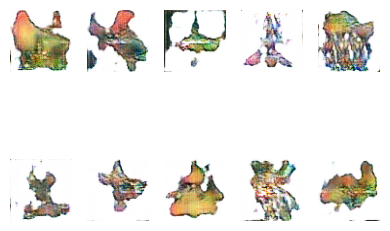

In [158]:
z = torch.randn(128, 100, 1, 1).to(device)
fake = gen(z)
fake = fake.detach().cpu().numpy()
fig, axes = plt.subplots(2, 5, figsize=(4,4))
for i in range(10):
        ax = axes[i // 5, i % 5]
        ax.imshow((np.transpose(fake[i], (1, 2, 0)) /2) + 0.5)  # Denormalize if necessary
        ax.axis('off')
plt.tight_layout()
plt.show()
